In [11]:
%load_ext autoreload
%autoreload 2


import jax
import jax.numpy as jnp

import qutip as qt
import matplotlib.pyplot as plt

from qbism import sic_povm
import jax.typing

import tomllib



import qdots_qll.all_funcs
from qdots_qll.models.models_scratch_for_drafting import *

from qdots_qll.models.game import vec, true_pars

from qdots_qll.distributions import initialize_particle_locations


import equinox as eqx


from jax import vmap

from jax import Array

# from jax.typing import ArrayLike
from jaxtyping import Array, Float, Complex, Int

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
boundaries = jnp.array(
    [
        [0.2, 0.4],
        [0.2, 0.4],
        [0.01, 0.09],
        [-0.2, -0.5],
    ]
)

In [3]:
covs = jnp.diagflat(jnp.std(boundaries, axis=1) / 5) ** 2

In [4]:
mus = jnp.mean(boundaries, axis=1)

In [5]:
covs

Array([[4.0000005e-04, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 4.0000005e-04, 0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 6.4000007e-05, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 8.9999998e-04]],      dtype=float32)

In [6]:
mus

Array([ 0.3 ,  0.3 ,  0.05, -0.35], dtype=float32)

In [7]:
seed = 10
key = jax.random.PRNGKey(seed)
key, subkey = jax.random.split(key)

In [8]:
no_particles = 1000

In [9]:
pars = jax.random.multivariate_normal(
    subkey, mean=mus, cov=covs, shape=(no_particles,)
)

In [14]:
pars.shape

(1000, 4)

In [13]:
key, subkey = jax.random.split(key)

initialize_particle_locations(
    subkey, 4, no_particles, boundaries=boundaries
).shape

(1000, 4)

In [10]:
from qdots_qll.utils.generate_initial_state import max_entangled_dm_vec
from qdots_qll.models.models_scratch_for_drafting import (
    two_qdots_separable_maps,
)

In [11]:
model = two_qdots_separable_maps(POVM_array=jnp.array(sic_povm(4)))

In [23]:
from qdots_qll.distributions import (
    initialize_weights,
    initialize_particle_locations_normal_prior,
)

In [44]:
weights = initialize_weights(no_particles)

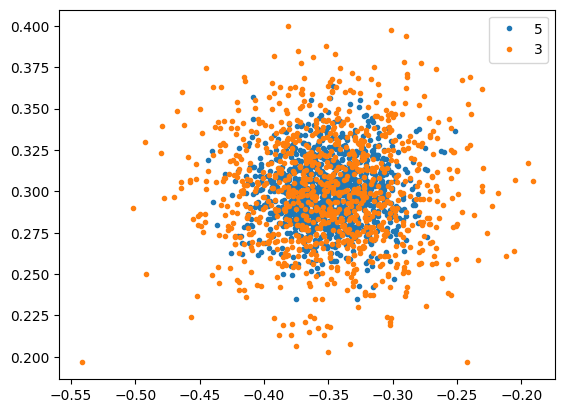

In [44]:
key, subkey = jax.random.split(key)
prior5 = initialize_particle_locations_normal_prior(
    subkey, no_particles, boundaries, sigmas=5
)
key, subkey = jax.random.split(key)

prior3 = initialize_particle_locations_normal_prior(
    subkey, no_particles, boundaries, sigmas=3
)


plt.plot(prior5[:, 3], prior5[:, 1], ".", label="5")
plt.plot(prior3[:, 3], prior3[:, 1], ".", label="3")
plt.legend()
plt.show()

In [56]:
(lambda particle, t: model.fim(particle, t, max_entangled_dm_vec))(
    pars[0], 20.0
)

Array([[ 0.7551327 , -0.5005927 , -0.03962149,  0.02354495],
       [-0.5005927 ,  0.71391356,  0.08787731, -0.08533304],
       [-0.03962149,  0.08787731,  2.5185547 , -1.5361819 ],
       [ 0.02354495, -0.08533304, -1.5361819 ,  0.9707818 ]],      dtype=float32)

In [57]:
def fim_at_time(prev_fim_at_time, time, pars):
    new = (lambda particle, t: model.fim(particle, t, max_entangled_dm_vec))(
        pars, time
    )
    return prev_fim_at_time + new, new

In [58]:
times = jnp.linspace(0, 40, 100)

In [62]:
jax.lax.scan(fim_at_time, 0, times)

TypeError: fim_at_time() missing 1 required positional argument: 'pars'

In [49]:
from optax import adam

In [66]:
def cum_fim(pars):
    def fim_at_time(prev_fim_at_time, time):
        new = (
            lambda particle, t: model.fim(particle, t, max_entangled_dm_vec)
        )(pars, time)
        return prev_fim_at_time + new, new

    times = jnp.linspace(0, 40, 100)
    return jax.lax.scan(fim_at_time, jnp.zeros((4, 4)), times)


cum_fim(pars[0])

Array([[ 7.17594910e+01, -4.68977585e+01,  1.18420529e+00,
         9.82229486e-02],
       [-4.68977585e+01,  6.08322983e+01,  3.34196568e+00,
        -4.88122940e+00],
       [ 1.18420529e+00,  3.34196568e+00,  1.78080261e+02,
        -1.06386215e+02],
       [ 9.82229486e-02, -4.88122940e+00, -1.06386215e+02,
         7.27126312e+01]], dtype=float32)